#  Introduction:
In this notebook we will go through Kaggle's Titanic dataset and use machine learning alghorithms to predict if a passanger in Titanic survived the disaster or not. During the process we will do an exploratory data analysis, future creation and selection, model creation and selection. This will be my first data science project after going through Kaggle's instructive notebooks and courses, without further ado let's get started.

# Loading the data:

In [1]:
#data analysis
import pandas as pd
import numpy as np
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plot graphs inline
%matplotlib inline


In [2]:
data_raw = pd.read_csv('trainTitanic.csv')
test_raw = pd.read_csv('testTitanic.csv')
# to avoid changing the original csv file, we create copies
data1 = data_raw.copy(deep = True)
test = test_raw.copy(deep = True)

In [3]:
data1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
features = data1.columns.drop('Survived')
target = data1.columns.drop(features)

In [6]:

#group for easier data cleaning
datas = [data1,test]

print("data1 dimensions:{0} ".format(data1.shape))
print("test dimensions: {0}".format(test.shape))

data1 dimensions:(891, 12) 
test dimensions: (418, 11)


In [7]:
catagoric = data1.loc[:, data1.dtypes == object].columns.tolist()
numeric = data1.loc[:, data1.dtypes != object].columns.tolist()
print('Catagoric features: {}'.format(catagoric))
print('Numeric features: {}' .format(numeric))

Catagoric features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numeric features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Dealing with missing values:

In [8]:
data1.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [9]:
test.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

## Cabin:

In [10]:
data1.Cabin.head

<bound method NDFrame.head of 0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object>

In [11]:
# over 3 quarters of cabin data in training data is missing that is i assume because passangers without any cabin were input as
# nan so making nan a catagory itself is viable, also all Cabin variables start with a letter which most likely represents the 
# are of the ship they were in so we will keep that as the cabin varaible and drop the numbers

for d in datas:
    d['Cabin'] = pd.Series( ['X' if pd.isnull(i) else i[0] for i in d.Cabin])
    
data1.Cabin.head

<bound method NDFrame.head of 0      X
1      C
2      X
3      C
4      X
      ..
886    X
887    B
888    X
889    C
890    X
Name: Cabin, Length: 891, dtype: object>

In [12]:
data1.groupby('Cabin').Cabin.count()

Cabin
A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
X    687
Name: Cabin, dtype: int64

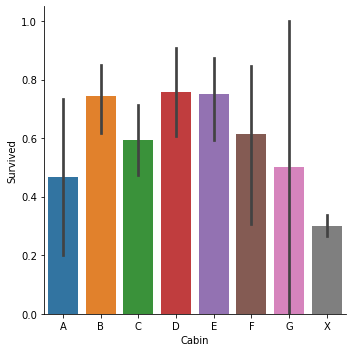

In [13]:
sns.catplot(y="Survived",x="Cabin",data=data1,kind="bar", order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'X'])
# Standart deviation for the cabin catagories are very high due to small sample size however passangers with X as their cabin
# have lower standart deviation and survival rate then passangers with cabin with sort of backs our assumption that missing
# cabin data indicated passangers without cabins.

## Age:

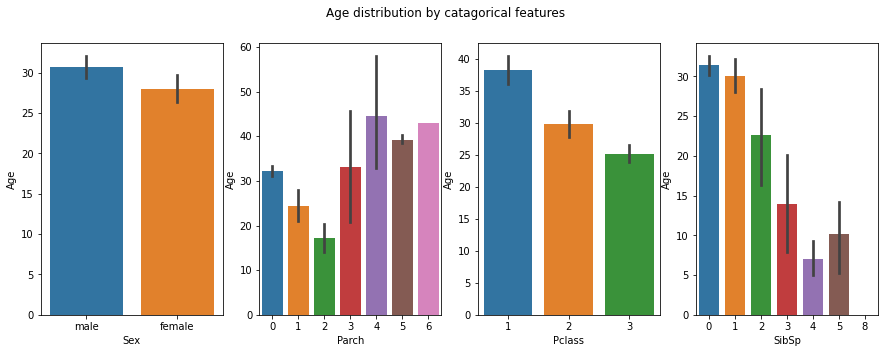

In [14]:
# we will impute missing Age values 
fig, axes = plt.subplots(1, 4, figsize= (15,5))
fig.suptitle('Age distribution by catagorical features')
sns.barplot(y= 'Age', x='Sex', data = data1, ax=axes[0])
sns.barplot(y= 'Age', x='Parch', data = data1, ax=axes[1])
sns.barplot(y= 'Age', x='Pclass', data = data1, ax=axes[2])
sns.barplot(y= 'Age', x='SibSp', data = data1, ax=axes[3])

In [15]:
#Pclass seems to do a good job at indicating age
for d in datas:
    d.Age = d.groupby('Pclass').Age.apply(lambda x: x.fillna(x.mean()))

## Fare:

In [16]:
#Fare in test is missing lets fill it
test.Fare = test.groupby('Pclass').Fare.apply(lambda x: x.fillna(x.mean()))

## Embarked:

In [17]:
# lets fill the embarked data with median since relatively low number of it is missing our imputation style shouldn't make much
# difference.

for d in datas:
    d.Embarked = d.Embarked.apply(lambda x: d.Embarked.mode()[0] if pd.isna(x) else x)

In [18]:
print('Any missing data:')
for d in datas:
    print(d.isnull().any())
    print('-'*40)

Any missing data:
PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool
----------------------------------------
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool
----------------------------------------


# Data Analysis:

In [87]:
print(numeric)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


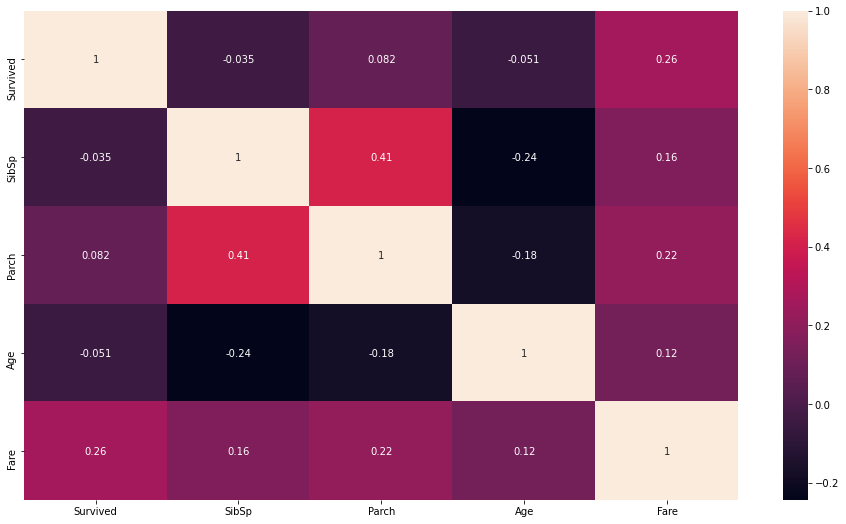

In [88]:
plt.figure(figsize=(16,9))
sns.heatmap(data1[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)

Fare seems to be a great indicator of survival, unfortunately money does save lives, Age and SibSp seems to have negative correlation and farely little correlation at that, however this does not mean those features are useless at indicating survival.

([<matplotlib.axis.XTick at 0x21c6f85a340>,
 <a list of 17 Text major ticklabel objects>)

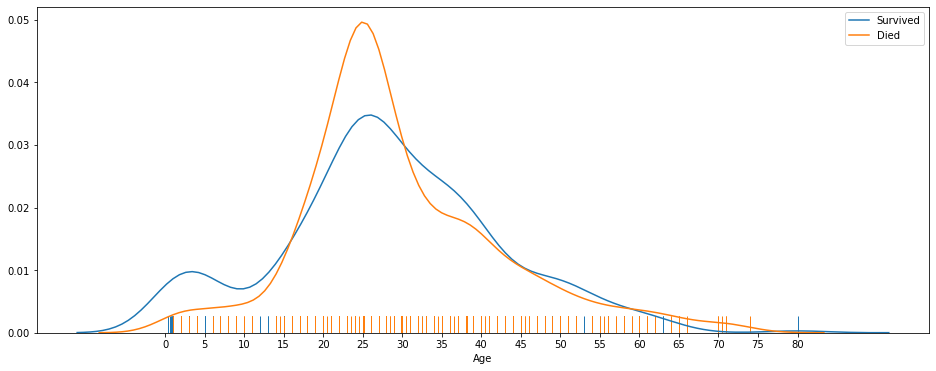

In [89]:
s = data1.loc[data1.Survived == 1]
d = data1.loc[data1.Survived == 0]
plt.figure(figsize=(16,6))
sns.distplot(s['Age'], hist=False, rug=True, label='Survived')
sns.distplot(d['Age'], hist=False, rug=True, label='Died')
plt.legend()
plt.xticks(list(range(0,81,5)))


The tail survived graph makes indicates children around 0-10 had a significantly higher chance of survival. Binning the age into several 

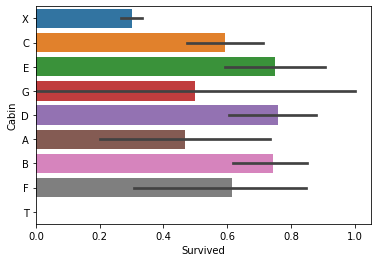

In [90]:
sns.barplot(x='Survived', y='Cabin', data=data1)

Cabin data has a lot of standard devieation.

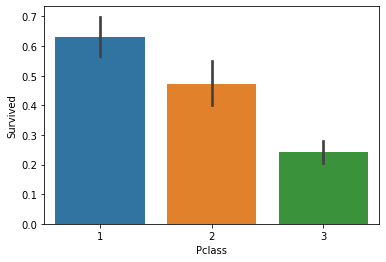

In [91]:
sns.barplot(x='Pclass', y='Survived', data=data1)

Pclass has a lot of influence on survival rate, probably higher class passangers were prioritized when abording the ship.

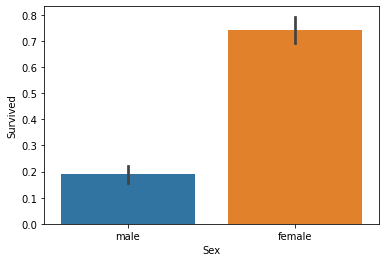

In [92]:
sns.barplot(x='Sex', y='Survived', data=data1)

Women and children indeed seems to be prioritized when abording, but we can still check maybe males were predominant in lower Pclasses so that might be affecting some

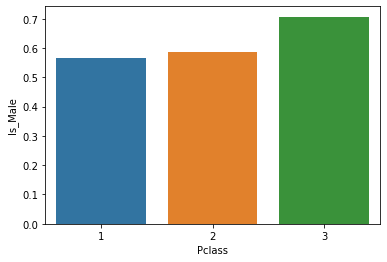

In [93]:
is_male = data1.Sex.map({'male': 1, 'female': 0})
pclass_is_male = pd.concat([is_male, data1.Pclass], axis=1)
pclass_is_male
pclass_is_male.rename(columns={"Sex": "Is_Male"}, inplace = True)
grp = pclass_is_male.groupby('Pclass').mean()
g = sns.barplot(x=grp.index, y=grp.Is_Male, data=grp)

Our assumption is somewhat true, in lower classes male passanger density is higher, but still sex on its own has a lot of affect on survival.

# Feature Engineering

## Name:
We can use the name feature, and get titles and families information out of it

In [94]:
data1.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [122]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

for d in datas:
    title = pd.Series(data1.Name.apply(get_title))
    d['Title'] = title

print('Test: \n{}' .format(test.Title.value_counts()))
print('-'*40)
print('Train: \n{}' .format(data1.Title.value_counts()))

Test: 
Mr        228
Miss      101
Mrs        58
Master     23
Dr          3
Rev         3
Don         1
Mme         1
Name: Title, dtype: int64
----------------------------------------
Train: 
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Don               1
Ms                1
Lady              1
Mme               1
Sir               1
Capt              1
Jonkheer          1
the Countess      1
Name: Title, dtype: int64


Lets group rare titles together and make sure both train and test data frames have same Title values.

In [124]:
for d in datas:
    d.Title = d.Title.map(lambda x: x if title.loc[title == x].count() > 10 else 'Rare')
print('Test: \n{}' .format(test.Title.value_counts()))
print('-'*40)
print('Train: \n{}' .format(data1.Title.value_counts()))

Test: 
Mr        228
Miss      101
Mrs        58
Master     23
Rare        8
Name: Title, dtype: int64
----------------------------------------
Train: 
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64
